In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np, pandas as pd, scipy
import astropy
from astropy import units as u
import astromet
#from astromet.track import design_matrix, design_1d
#import dev.astromet.astromet as astromet
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import scanninglaw.times
from scanninglaw.source import Source

In [3]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=2
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

In [4]:
dr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

# Load in scanning law
- Requires scanninglaw installed
- Takes up a bit of memory (~1Gb I think)

In [5]:
# slooow step - see scanning_law package for details
dr3_sl=scanninglaw.times.dr2_sl(version='dr3_nominal')

Loading auxilliary data ...
t = 62.869 s
  auxilliary:  39.868 s
          sf:   6.280 s
interpolator:  16.721 s


# Single source

In [35]:
# System astrometry parameters
params=astromet.params()
params.ra=360*np.random.rand()
params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
params.pmrac=params.parallax*(20/3)*np.random.randn()
params.pmdec=params.parallax*(20/3)*np.random.randn()

mag=np.random.rand()*6+15

c=Source(params.ra,params.dec,unit='deg')
sl=dr3_sl(c, return_times=True, return_angles=True)
ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
sort=np.argsort(ts)
ts=ts[sort]
phis=np.squeeze(np.hstack(sl['angles']))[sort]

In [36]:
drac_track, ddec_track=astromet.track(ts,params)

In [37]:
x_err = astromet.sigma_ast(mag)
# gaia makes 9 measurements per transit (with random error)
t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,drac_track,ddec_track,err=x_err)

In [38]:
params.ra, params.dec, params.parallax, params.pmrac, params.pmdec

(42.16126965974172,
 9.253703477458414,
 17.89776745852331,
 107.5593154874244,
 27.799212908305783)

In [42]:
# 'pmra' in gaia data is pmra*cos(dec) 
results=astromet.fit(t_obs,x_obs,phi_obs,x_err,params.ra,params.dec)
gaia_output=astromet.gaia_results(results)
gaia_output

{'astrometric_matched_transits': 22,
 'visibility_periods_used': 14,
 'astrometric_n_obs_al': 198,
 'astrometric_params_solved': 31,
 'ra': 42.16126949440847,
 'ra_error': 0.2055671688119015,
 'dec': 9.253703497013882,
 'dec_error': 0.19674890792243863,
 'ra_dec_corr': 0.20143441452370692,
 'parallax': 17.671361343301232,
 'parallax_error': 0.24178681286403386,
 'ra_parallax_corr': -0.14535654648653645,
 'dec_parallax_corr': 0.26018965344032924,
 'pmra': 107.83091260027938,
 'pmra_error': 0.27166068975283186,
 'ra_pmra_corr': 0.15466436244521048,
 'dec_pmra_corr': 0.18837003101958333,
 'parallax_pmra_corr': -0.19350700490684136,
 'pmdec': 28.08604680081704,
 'pmdec_error': 0.23127232911889517,
 'ra_pmdec_corr': 0.26137995395472496,
 'dec_pmdec_corr': 0.27813053518390934,
 'parallax_pmdec_corr': -0.17415119227783135,
 'pmra_pmdec_corr': 0.2595997200328514,
 'astrometric_excess_noise': 0.0,
 'astrometric_chi2_al': 211.134214253347,
 'astrometric_n_good_obs_al': 198,
 'UWE': 1.04592526470

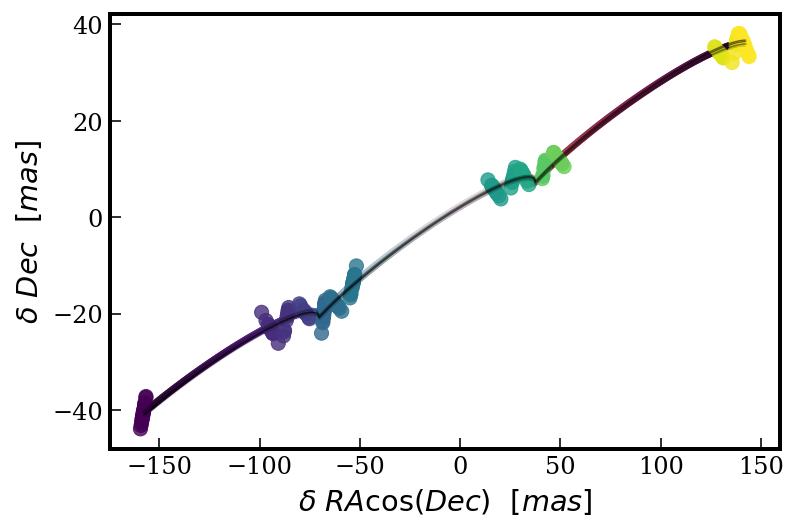

In [43]:
# optionally plot tracks
plotts=np.linspace(ts[0],ts[-1],1000)
cs=mpl.cm.twilight_shifted(np.interp(plotts,[plotts[0],plotts[-1]],[0,1]))

plotRacs,plotDecs=astromet.track(plotts,params)

ax=plt.gca()
fitparams=astromet.params()
for i in range(16):
    fitparams.ra=params.ra
    fitparams.dec=params.dec
    fitparams.drac=results['drac']+np.random.randn()*results['drac_error']
    fitparams.ddec=results['ddec']+np.random.randn()*results['ddec_error']
    fitparams.pmrac=results['pmrac']+np.random.randn()*results['pmrac_error']
    fitparams.pmdec=results['pmdec']+np.random.randn()*results['pmdec_error']
    fitparams.parallax=results['parallax']+np.random.randn()*results['parallax_error']

    fitRacs,fitDecs=astromet.track(plotts,fitparams)
    ax.plot(fitRacs,fitDecs,c='k',alpha=0.2,lw=0.5)
ax.scatter(plotRacs,plotDecs,c=cs,s=10,alpha=0.8)
plt.scatter(rac_obs, dec_obs, c=t_obs,s=50,alpha=0.8)
ax.set_xlabel(r'$\delta \ RA \cos(Dec) \ \ [mas]$')
ax.set_ylabel(r'$\delta \ Dec \ \ [mas]$')

plt.show()

### UWE~1 and astrometric_excess_noise is small (as expected without binary motion)

# Binary source

In [51]:
# System astrometry parameters
params=astromet.params()
params.ra=360*np.random.rand()
params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
params.pmrac=params.parallax*np.random.normal(scale=6.67)
params.pmdec=params.parallax*np.random.normal(scale=6.67)

mag=np.random.rand()*6+10

c=Source(params.ra,params.dec,unit='deg')
sl=dr3_sl(c, return_times=True, return_angles=True)
ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
sort=np.argsort(ts)
ts=ts[sort]
phis=np.squeeze(np.hstack(sl['angles']))[sort]

params.period=10**(-1.5+3*np.random.rand()) # periods between 0.03 and 30 years
params.l=np.random.rand() # uniform light ratio
params.q=4*np.random.rand()**2 # mass ratios between 0 and 4 (half less than 1)
params.a=10*np.random.rand()**2
params.e=np.random.rand()
params.vtheta=np.arccos(-1+2*np.random.rand())
params.vphi=2*np.pi*np.random.rand()
params.vomega=2*np.pi*np.random.rand()
orbitalPhase=np.random.rand() # fraction of an orbit completed at t=0
params.tperi=params.period*orbitalPhase

In [52]:
drac_track, ddec_track=astromet.track(ts,params)

In [53]:
x_err = astromet.sigma_ast(mag)
t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,drac_track,ddec_track,err=x_err)

In [54]:
params.ra, params.dec, params.parallax, params.pmrac, params.pmdec

(343.49026309922425,
 -62.87498722877596,
 18.555490357014126,
 -202.5486643031172,
 143.54948077010835)

In [55]:
# 'pmra' in gaia data is pmra*cos(dec) 
results=astromet.fit(t_obs,x_obs,phi_obs,x_err,params.ra,params.dec)
gaia_output=astromet.gaia_results(results)
gaia_output

{'astrometric_matched_transits': 55,
 'visibility_periods_used': 27,
 'astrometric_n_obs_al': 495,
 'astrometric_params_solved': 31,
 'ra': 343.4902608020281,
 'ra_error': 0.33430954237505506,
 'dec': -62.87498826874897,
 'dec_error': 0.3588710885862217,
 'ra_dec_corr': -0.3451317361925983,
 'parallax': 12.838540461082989,
 'parallax_error': 0.45090502147811357,
 'ra_parallax_corr': -0.16613581159199037,
 'dec_parallax_corr': 0.20437052378971582,
 'pmra': -186.8130127096437,
 'pmra_error': 0.40310807129432735,
 'ra_pmra_corr': -0.11951414330157709,
 'dec_pmra_corr': 0.2015672253657348,
 'parallax_pmra_corr': 0.16198686022411776,
 'pmdec': 139.42795936791458,
 'pmdec_error': 0.46441528795992093,
 'ra_pmdec_corr': 0.16503321553096628,
 'dec_pmdec_corr': -0.16693075718536252,
 'parallax_pmdec_corr': 0.0651336113951261,
 'pmra_pmdec_corr': -0.36054275109579526,
 'astrometric_excess_noise': 25.0378144564245,
 'astrometric_chi2_al': 434409002.95808876,
 'astrometric_n_good_obs_al': 495,
 'UW

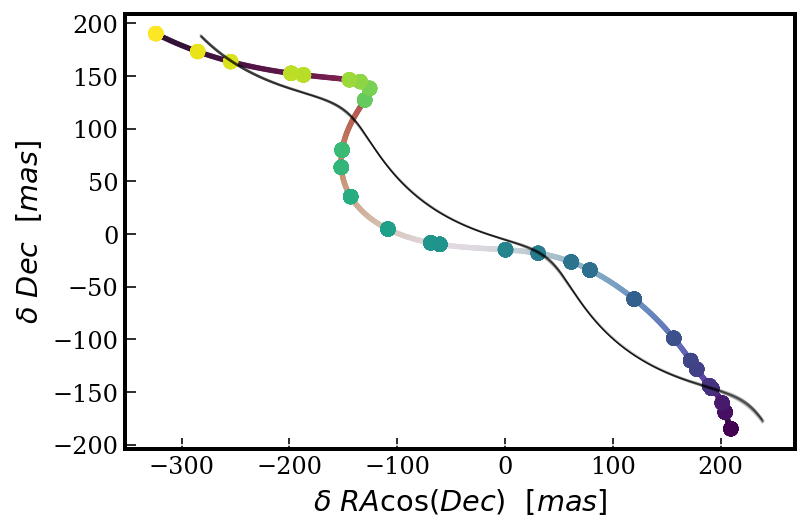

In [58]:
# optionally plot tracks
plotts=np.linspace(ts[0],ts[-1],1000)
cs=mpl.cm.twilight_shifted(np.interp(plotts,[plotts[0],plotts[-1]],[0,1]))

plotRacs,plotDecs=astromet.track(plotts,params)

ax=plt.gca()
fitparams=astromet.params()
for i in range(16):
    fitparams.ra=params.ra
    fitparams.dec=params.dec
    fitparams.drac=results['drac']+np.random.randn()*results['drac_error']
    fitparams.ddec=results['ddec']+np.random.randn()*results['ddec_error']
    fitparams.pmrac=results['pmrac']+np.random.randn()*results['pmrac_error']
    fitparams.pmdec=results['pmdec']+np.random.randn()*results['pmdec_error']
    fitparams.parallax=results['parallax']+np.random.randn()*results['parallax_error']

    fitRacs,fitDecs=astromet.track(plotts,fitparams)
    ax.plot(fitRacs,fitDecs,c='k',alpha=0.2,lw=0.5)
ax.scatter(plotRacs,plotDecs,c=cs,s=5,alpha=0.8)
plt.scatter(rac_obs, dec_obs, c=t_obs,s=50,alpha=0.8)
ax.set_xlabel(r'$\delta \ RA \cos(Dec) \ \ [mas]$')
ax.set_ylabel(r'$\delta \ Dec \ \ [mas]$')

plt.show()

### UWE is bigger and astrometric_excess_noise>0!